# MELD Dataset

In this notebook I prepare and wrangle the MELD training data for the purpose of emotion classification.

I first got a sense of the tabular labeled CSV data. I listened to the outlier short and long utterances which lead me to remove to unintelligle short utterances. I noted that 6 speakers comprise 83% of the data and the presence of a 17x class imbalance b/w fear and neutral and b/w digust and neutral.

I then investigated the following feature extraction methods: Mel-scaled spectrogram,
Mel-frequency cepstral coefficients, Chroma. 
The features produced by these methods are individually weakly correlated with the DV, emotion. Each of the three sets of features can be reduced using PCA and still capture a significant portion of the data's characteristics. This would be especially useful for reducing the 128 melspectrogram features down to ~50 to reduce model complexity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython 
import librosa as lb
import seaborn as sns

## Training Data

The emotion labels I am interested in are stored in CSV with each item uniquely ID'd by Dialogue_ID and Utterance_ID.  The raw audio will be obtained later from MP4 video files.

In [425]:
train_df = pd.read_csv('data/train_labels.csv')
train_df.head(2)

Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my companys tr...         Chandler   
1       2                   You mustve had your hands full.  The Interviewer   

   Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0  neutral   neutral            0             0       8       21   
1  neutral   neutral            0             1       8       21   

      StartTime       EndTime  
0  00:16:16,059  00:16:21,731  
1  00:16:21,940  00:16:23,442

In [373]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9989 non-null   int64 
 1   Utterance     9989 non-null   object
 2   Speaker       9989 non-null   object
 3   Emotion       9989 non-null   object
 4   Sentiment     9989 non-null   object
 5   Dialogue_ID   9989 non-null   int64 
 6   Utterance_ID  9989 non-null   int64 
 7   Season        9989 non-null   int64 
 8   Episode       9989 non-null   int64 
 9   StartTime     9989 non-null   object
 10  EndTime       9989 non-null   object
dtypes: int64(5), object(6)
memory usage: 858.6+ KB


## Dev (CV) Data

In [376]:
dev_df = pd.read_csv('data/dev_labels.csv')
dev_df.head(2)

Sr No.                                       Utterance Speaker   Emotion  \
0       1  Oh my God, hes lost it. Hes totally lost it.  Phoebe   sadness   
1       2                                           What?  Monica  surprise   

  Sentiment  Dialogue_ID  Utterance_ID  Season  Episode     StartTime  \
0  negative            0             0       4        7  00:20:57,256   
1  negative            0             1       4        7  00:21:01,927   

        EndTime  
0  00:21:00,049  
1  00:21:03,261

In [377]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        1109 non-null   int64 
 1   Utterance     1109 non-null   object
 2   Speaker       1109 non-null   object
 3   Emotion       1109 non-null   object
 4   Sentiment     1109 non-null   object
 5   Dialogue_ID   1109 non-null   int64 
 6   Utterance_ID  1109 non-null   int64 
 7   Season        1109 non-null   int64 
 8   Episode       1109 non-null   int64 
 9   StartTime     1109 non-null   object
 10  EndTime       1109 non-null   object
dtypes: int64(5), object(6)
memory usage: 95.4+ KB


## Test Data

In [4]:
test_df = pd.read_csv('data/test_sent_emo.csv')
test_df.head(5)

Sr No.                                          Utterance Speaker  \
0       1  Why do all youre coffee mugs have numbers on ...    Mark   
1       2  Oh. Thats so Monica can keep track. That way ...  Rachel   
2       3                                       Y'know what?  Rachel   
3      19                     Come on, Lydia, you can do it.    Joey   
4      20                                              Push!    Joey   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0  surprise  positive            0             0       3       19   
1     anger  negative            0             1       3       19   
2   neutral   neutral            0             2       3       19   
3   neutral   neutral            1             0       1       23   
4       joy  positive            1             1       1       23   

      StartTime       EndTime  
0  00:14:38,127  00:14:40,378  
1  00:14:40,629  00:14:47,385  
2  00:14:56,353  00:14:57,520  
3   0:10:44,769   0:10:46,146  
4   0:10:46,146   0:10:46,833

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


## Data Wrangling and Exploration

### Missing Values

In [378]:
def df_missing_any(df) -> bool:
    # isna: NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike
    return df.isna().values.any()

assert not df_missing_any(train_df)
assert not df_missing_any(dev_df)
assert not df_missing_any(test_df)

### Construct unique id 

In [452]:
def add_dia_utt(dataframe):
    # feature vectors and audtio files are stored by 'dia_utt' so create that in the df
    cols = ['Dialogue_ID', 'Utterance_ID']
    dataframe['dia_utt'] = dataframe[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

add_dia_utt(train_df)
print(train_df['dia_utt'])
assert train_df['dia_utt'].is_unique

0           0_0
1           0_1
2           0_2
3           0_3
4           0_4
         ...   
9984    1038_13
9985    1038_14
9986    1038_15
9987    1038_16
9988    1038_17
Name: dia_utt, Length: 9989, dtype: object


In [453]:
add_dia_utt(dev_df)
print(dev_df['dia_utt'])
assert dev_df['dia_utt'].is_unique

0          0_0
1          0_1
2          1_0
3          1_1
4          1_2
         ...  
1104     113_9
1105    113_10
1106    113_11
1107    113_12
1108    113_13
Name: dia_utt, Length: 1109, dtype: object


In [454]:
add_dia_utt(test_df)
print(test_df['dia_utt'])
assert test_df['dia_utt'].is_unique

0          0_0
1          0_1
2          0_2
3          1_0
4          1_1
         ...  
2605    279_11
2606    279_12
2607    279_13
2608    279_14
2609    279_15
Name: dia_utt, Length: 2610, dtype: object


### Column-wise Exploration

#### Utterance

count    9989.000000
mean       40.528381
std        31.953528
min         1.000000
25%        16.000000
50%        32.000000
75%        58.000000
max       327.000000
Name: Utterance_len, dtype: float64


Text(0.5, 1.0, 'Frequency vs. Utterance length')

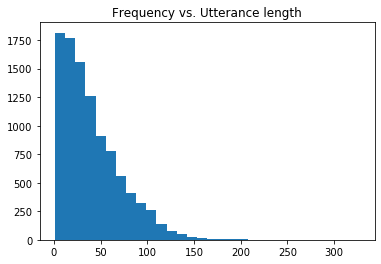

In [9]:
train_df['Utterance_len'] = train_df['Utterance'].apply(len)
print(train_df.Utterance_len.describe())
plt.hist(train_df.Utterance_len, bins=30)
plt.title('Frequency vs. Utterance length')

Most of the utterances are short, but there are some long ones too. Next I will take a close look at the short utterances.

Text(0.5, 1.0, 'Frequency vs. Small Utterance length')

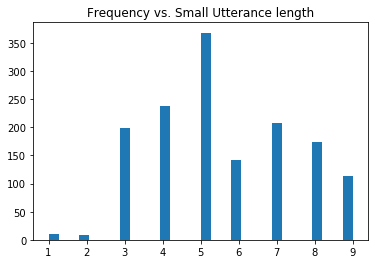

In [14]:
plt.hist(train_df.Utterance_len[train_df.Utterance_len < 10], bins=30)
plt.title('Frequency vs. Small Utterance length')

These must be one word utterances. 

In [15]:
train_df.Utterance[train_df.Utterance_len < 3].value_counts()
# Check out the outlier short utterances

I     10
No     2
Is     1
Wh     1
!      1
We     1
Hi     1
Eh     1
In     1
It     1
Name: Utterance, dtype: int64

Ok, some of these are sensible one-word uttearnces, but some may be "junk."

I want to hear these outlier small utterances to determine whether they should be included. 

In [16]:
import librosa
import os

short_audio_paths = []
for i, id in train_df.dia_utt[train_df.Utterance_len < 3].iteritems():
    path = 'data/audio/' + id + '.wav'
    short_audio_paths.append(os.path.join(os.getcwd(), path))
    
print(len(short_audio_paths))

20


In [ ]:
def display_audio_from(path: str):
    audio, sr = librosa.load(fp)
    IPython.display.Audio(audio, rate=sr)

    
for sap in short_audio_paths:
    audio, sr = librosa.load(sap)
    print(sap)
    IPython.display.display(IPython.display.Audio(audio, rate=sr))

These utterances are unintelligble to me:
    
- 351_11.wav 
- 430_8.wav 

Given their labels below, I think it is best to remove them.

In [29]:
train_df[train_df.dia_utt == '351_11']

Sr No. Utterance Speaker Emotion Sentiment  Dialogue_ID  Utterance_ID  \
3339    3527        Wh    Mona     joy  positive          351            11   

      Season  Episode    StartTime      EndTime dia_utt  Utterance_len  
3339       8        8  0:12:06,480  0:12:06,732  351_11              2

In [30]:
train_df[train_df.dia_utt == '430_8']

Sr No. Utterance Speaker Emotion Sentiment  Dialogue_ID  Utterance_ID  \
3991    4209        No    Joey   anger  negative          430             8   

      Season  Episode     StartTime       EndTime dia_utt  Utterance_len  
3991       6        2  00:02:16,553  00:02:18,011   430_8              2

In [33]:
print(train_df.shape)
train_df.drop(train_df[train_df.dia_utt == '351_11'].index, inplace=True)
train_df.drop(train_df[train_df.dia_utt == '430_8'].index, inplace=True)
print(train_df.shape)

(9989, 13)
(9987, 13)


Next I want to look at the utterances with outlier length.

Text(0.5, 1.0, 'Frequency vs. Big Utterance length')

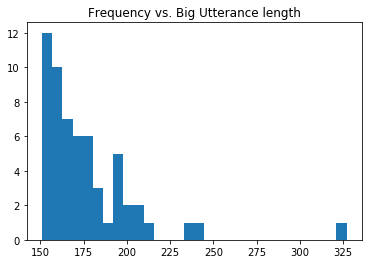

In [18]:
# Looks like there are some longer dialogues thay may have to be split in smaller chunks
plt.hist(train_df.Utterance_len[train_df.Utterance_len > 150], bins=30)
plt.title('Frequency vs. Big Utterance length')

Make the few lenghty outliers audible...

In [19]:
for i, id in train_df.dia_utt[train_df.Utterance_len > 200].iteritems():
    path = 'data/audio/' + id + '.wav'
    path = os.path.join(os.getcwd(), path)
    
    audio, sr = librosa.load(path)
    print('\n', path)
    IPython.display.display(IPython.display.Audio(audio, rate=sr))


 /Users/home/PycharmProjects/springboard_mle_project/capstone/poc/data/audio/152_11.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/poc/data/audio/383_1.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/poc/data/audio/455_11.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/poc/data/audio/510_0.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/poc/data/audio/644_5.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/poc/data/audio/647_0.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/poc/data/audio/757_2.wav


Listening to these longer clips, I judge that the overall emotion is stable, there's just a long dialogue. However, these make me realize that there are often unedited 'laugh tracks' included in the utterances which surely will influence the results. The laugh tracks usually come in towards the end of the utterance, so I suspect that focusing on the earlier part of the utterance will reduce their influence. Perhaps for a given utterance I could perform class inference multiple times on different segments of longer utterances.

#### Speaker column exploration

In [20]:
speaker_counts = train_df['Speaker'].value_counts()
speaker_counts

Joey                1509
Ross                1459
Rachel              1435
Phoebe              1321
Monica              1299
                    ... 
Phoebe/Waitress        1
Vince                  1
Gary Collins           1
Hold Voice             1
Front Desk Clerk       1
Name: Speaker, Length: 260, dtype: int64

In [21]:
top_speakers = speaker_counts[speaker_counts > 100]
top_speakers

Joey        1509
Ross        1459
Rachel      1435
Phoebe      1321
Monica      1299
Chandler    1283
Name: Speaker, dtype: int64

In [22]:
round(100 * sum(top_speakers) / sum(speaker_counts), 2)

83.15

83 % of the data comes from the 6 main characters, this could lead to overfitting on their voices

#### Emotion column exploration

Emotion is the main DV I wish to predict

In [23]:
emo_cnts = train_df['Emotion'].value_counts(normalize=True)
emo_cnts * 100

neutral     47.151867
joy         17.449194
surprise    12.063270
anger       11.102212
sadness      6.837521
disgust      2.712984
fear         2.682951
Name: Emotion, dtype: float64

Highlight the class imbalance by normalizing on largest class

In [24]:
emo_cnts.neutral / emo_cnts 

neutral      1.000000
joy          2.702238
surprise     3.908714
anger        4.247069
sadness      6.896047
disgust     17.380074
fear        17.574627
Name: Emotion, dtype: float64

The emotion classes are somewhat imbalanced. Neutral is overrepresented, while sadness, disgust, and fear are underrepresented. For instance, neutral occurs 17x more than digust and fear.  "Most of the contemporary works in class imbalance concentrate on imbalance ratios
 ranging from 1:4 up to 1:100" (https://link.springer.com/article/10.1007/s13748-016-0094-0 )

Some ideas to consider to address: 

- over-sampling underrepresented classes since dataset size is on the smaller end
- using random and non-random (e.g. stratified) sampling schemes
- using tree-based menthods which often perform well on imbalanced datasets
- using regularization to avoid overfitting
- combining the negative emotions into 1 group to simplify the problem and increase the data per class

#### Sentiment column exploration



In [25]:
sent_counts = train_df['Sentiment'].value_counts(normalize=True)
sent_counts

neutral     0.471519
negative    0.294824
positive    0.233657
Name: Sentiment, dtype: float64

The sentiment classes are fairly balanced, 
i.e. difference b/w neutral and positive is 2x 

#### Dialogue_ID

In [26]:
dialog_counts = train_df['Dialogue_ID'].value_counts(sort=True)
print('total dialogs ', len(dialog_counts))
print(dialog_counts)

total dialogs  1038
523    24
54     24
450    24
649    24
530    24
       ..
987     1
790     1
581     1
490     1
742     1
Name: Dialogue_ID, Length: 1038, dtype: int64


Utterance distribution across dialogues is reasonable. Most occurrences is 24 out of 1038 for some dialogs.

#### Utterance_ID

Based on Dialog id counts this should range from 0-23

In [27]:
train_df['Utterance_ID'].value_counts()

0     1028
1      965
2      899
3      848
4      803
5      733
6      676
7      603
8      536
9      483
10     433
11     378
12     322
13     282
14     246
15     215
16     157
17     123
18      93
19      69
20      48
21      30
22      14
23       5
Name: Utterance_ID, dtype: int64

#### Season

In [28]:
train_df['Season'].value_counts().sort_index()

1    1402
2     289
3    1609
4    1129
5    1265
6    1317
7    1380
8    1108
9     490
Name: Season, dtype: int64

Seasons 2, 9 are slightly underrepresented but this shouldn't have an effect.

#### Episode

In [29]:
train_df['Episode'].value_counts().sort_index()

1     396
2     469
3     368
4     440
5     630
6     417
7     364
8     218
9     294
10    456
11    440
12    586
13    334
14    429
15    365
16    259
17    410
18    388
19    355
20    361
21    398
22    392
23    686
24    381
25    153
Name: Episode, dtype: int64

Summary of labels and metdata exploration

- there are some outlier utterance in terms of length, small and large
- 6 speakers comprise 83% of the data
- 17x class imbalance b/w fear and neutral and b/w digust and neutral

### Encoding

__Must convert the emotion labels to numeric. Use ordinal encoding__


In [458]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

train_df['emotion_class'] = label_encoder.fit_transform(train_df['Emotion'])
train_df[['Emotion', 'emotion_class']].head()

Emotion  emotion_class
0   neutral              4
1   neutral              4
2   neutral              4
3   neutral              4
4  surprise              6

In [465]:
dev_df['emotion_class'] = label_encoder.transform(dev_df['Emotion'])
dev_df[['Emotion', 'emotion_class']].head()

Emotion  emotion_class
0   sadness              5
1  surprise              6
2   neutral              4
3       joy              3
4   sadness              5

In [459]:
test_df['emotion_class'] = label_encoder.transform(test_df['Emotion'])
test_df[['Emotion', 'emotion_class']].head()

Emotion  emotion_class
0  surprise              6
1     anger              0
2   neutral              4
3   neutral              4
4       joy              3

# Audio File Wrangling and Exploration

In [32]:
import os
meld_path = '/Users/home/Desktop/ml-eng/datasets/MELD'
meld_audio_rel_path = 'MELD.Raw/train/train_splits'
audio_path = os.path.join(meld_path, meld_audio_rel_path)
mp4_paths = [os.path.join(audio_path, fname) for fname in os.listdir(audio_path)]
print(len(mp4_paths))
print(mp4_paths[0])

9989
/Users/home/Desktop/ml-eng/datasets/MELD/MELD.Raw/train/train_splits/dia47_utt11.mp4


#### Convert mp4 to mp3

In [414]:
import moviepy.editor as mp


def convert_mp4_to_mp3(path: str):
    finished = set(f.split('.')[0] for f in os.listdir(path) if f.split('.')[1] == 'wav')
    print('already finished: ', len(finished))

    fails = []
    mp4_paths = [os.path.join(path, f) for f in os.listdir(path) if f.split('.')[1] == 'mp4']
    for mp4_path in mp4_paths:
        fname = mp4_path.split('/')[-1].split('.')[0]
        fname = fname.replace('dia', '').replace('utt', '').replace('final_videos_test', '')
        if fname in finished:
            continue

        try:
            clip = mp.VideoFileClip(mp4_path)

            # pick highest quality kwargs based on https://zulko.github.io/moviepy/ref/AudioClip.html
            out_path = os.path.join(path, fname + '.wav')
            clip.audio.write_audiofile(out_path, nbytes=4, codec='pcm_s32le', bitrate='3000k')
        except Exception as e:
            fails.append(e) 

    print(f'Finished with {len(fails)} failure(s): {fails}')
    

In [415]:
convert_mp4_to_mp3('data/audio/train')

already finished:  9986
Finished with 0 failure(s): []


In [417]:
convert_mp4_to_mp3('data/audio/dev')


already finished:  1112
Finished with 0 failure(s): []


In [419]:
convert_mp4_to_mp3('data/audio/test')


already finished:  2747
Finished with 0 failure(s): []


In [440]:
train_path = 'data/audio/train'
train_wav_paths = [os.path.join(train_path, fname) for fname in os.listdir(train_path)]
print(len(train_wav_paths))
print(train_wav_paths[:3])

9986
['data/audio/train/813_8.wav', 'data/audio/train/141_5.wav', 'data/audio/train/902_5.wav']


In [441]:
dev_path = 'data/audio/dev'
dev_wav_paths = [os.path.join(dev_path, fname) for fname in os.listdir(dev_path)]
print(len(dev_wav_paths))
print(dev_wav_paths[:3])

1112
['data/audio/dev/104_5.wav', 'data/audio/dev/90_3.wav', 'data/audio/dev/56_5.wav']


In [442]:
test_path = 'data/audio/test'
test_wav_paths = [os.path.join(test_path, fname) for fname in os.listdir(test_path)]
print(len(test_wav_paths))
print(test_wav_paths[:3])

2747
['data/audio/test/112_12.wav', 'data/audio/test/268_9.wav', 'data/audio/test/218_0.wav']


Load all wav files into an array including the UID

In [445]:
from random import sample
import librosa


def path_to_id(path: str) -> str:
    return path.split('/')[-1].split('.')[0]


def load_audio(paths: list, sample_size: int):
    rows = list()
    for path in sample(paths, sample_size):
        uid = path_to_id(path)
        audio, sr = librosa.load(path)
        rows.append([uid, audio, sr])
    return rows
        
def standard_scale(X):
    return (X - np.mean(X)) / np.std(X)

In [455]:
# take the wav paths and construct a dataframe

def audio_to_df(paths: list, labels_df):
    rows = load_audio(paths, len(paths))
    
    # standardize all signals to have mean zero and unit variance
    for i, row in enumerate(rows):
        rows[i][1] = standard_scale(row[1])
        
    # Construct new DF to focus on the feature processing
    df = pd.DataFrame(rows)
    df.columns = ['dia_utt', 'audio', 'sr']
    df.set_index('dia_utt')
    df.dia_utt = df.dia_utt.astype(str)

    
    labels_df.dia_utt = labels_df.dia_utt.astype(str)
    
    #Add in the emotion label and numeric class
    labels_df.set_index('dia_utt')
    return df.merge(labels_df[['dia_utt', 'Emotion', 'emotion_class']], on='dia_utt')


In [474]:
train_audio_df = audio_to_df(train_wav_paths, train_df) # entire set takes ~19 minutes
train_audio_df.head(1)

dia_utt                                              audio     sr Emotion  \
0   392_4  [-0.49475193, -0.3467554, 0.43902704, 0.774604...  22050     joy   

   emotion_class  
0              3

In [466]:
dev_audio_df = audio_to_df(dev_wav_paths, dev_df)
dev_audio_df.head(1)

dia_utt                                              audio     sr  Emotion  \
0    31_3  [0.032562077, 0.0987017, 0.037303194, -0.04153...  22050  neutral   

   emotion_class  
0              4

In [467]:
test_audio_df = audio_to_df(test_wav_paths, test_df)
test_audio_df.head(1)

dia_utt                                              audio     sr  Emotion  \
0  203_12  [1.6499888, 2.95568, 1.1696037, -0.7457437, -1...  22050  neutral   

   emotion_class  
0              4

## EDA of audio files

(array([7.780e+02, 2.107e+03, 2.300e+03, 1.553e+03, 1.002e+03, 5.870e+02,
        4.140e+02, 3.550e+02, 2.570e+02, 1.890e+02, 1.340e+02, 9.200e+01,
        5.700e+01, 5.600e+01, 3.300e+01, 2.200e+01, 1.000e+01, 1.500e+01,
        6.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1764.  ,  19836.18,  37908.36,  55980.54,  74052.72,  92124.9 ,
        110197.08, 128269.26, 146341.44, 164413.62, 182485.8 , 200557.98,
        218630.16, 236702.34, 254774.52, 272846.7 , 290918.88, 308991.06,
        327063.24, 345135.42, 363207.6 , 381279.78, 399351.96, 417424.14,
        435496.32, 453568.5 , 471640.68, 489712.86, 507785.04, 525857.22,
      

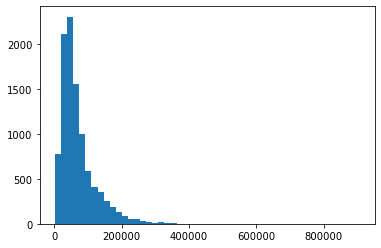

In [483]:
train_audio_df['audio_len'] = train_audio_df['audio'].apply(len)
plt.hist(train_audio_df['audio_len'], bins=50)

In [484]:
train_audio_df['audio_len'].describe()

count      9986.000000
mean      69574.670439
std       53545.275508
min        1764.000000
25%       34619.000000
50%       54684.000000
75%       86877.000000
max      905373.000000
Name: audio_len, dtype: float64

## Feature Extraction

### Mel-scaled spectrogram

- time-frequency representation of sound
- sampled into a number of points around equally spaced times and frequencies on a Mel frequency scale
- Mel frequency scale: mel = 2595 * log10 (1 + hertz / 700)
- constructed such that sounds of equal distance from each other on the Mel Scale, also sound to humans as they are equal distance from on another
- in contrast to Hz scale where 500-1000 hz is obvious but 7500 to 8000 barely noticeable


In [230]:
# select sample
dia_utt, y, sr, label, y_len, clz = train_audio_df.head(1).values[0]
print('id ', dia_utt, '\nsize ', y_len, '\nlabel ', label)

id  248_1 
size  0 
label  anger


In [231]:
IPython.display.display(IPython.display.Audio(y, rate=sr))

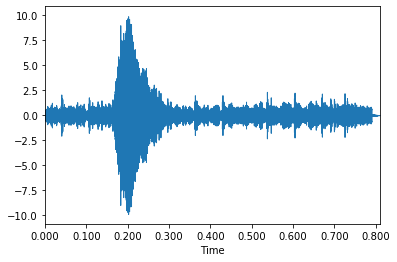

In [232]:
from librosa.display import waveplot
waveplot(y, sr=sr)

Apply FFT

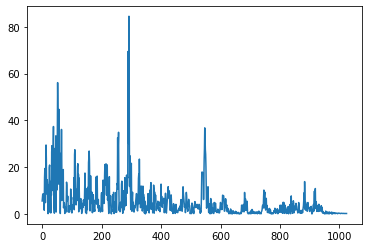

In [233]:
import numpy as np
import matplotlib.pyplot as plt

n_fft = 2048
D = np.abs(librosa.stft(y[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))
plt.plot(D)

FFT + time windows

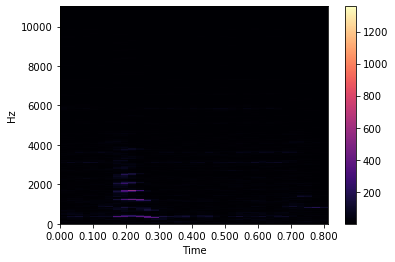

In [234]:
hop_length = 512
D = np.abs(librosa.stft(y, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

Time windows transformed to DB scale

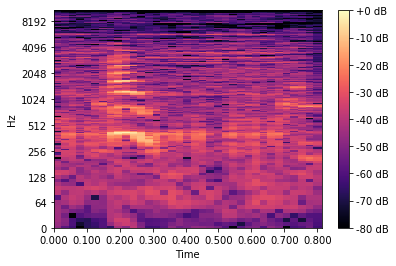

In [235]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

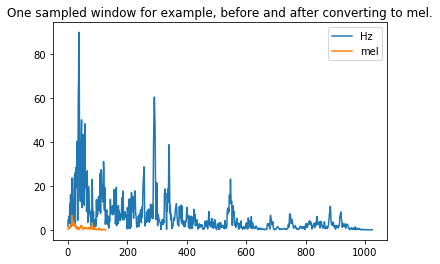

In [236]:
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

plt.plot(D[:, 1]);
plt.plot(mel.dot(D[:, 1]));
plt.legend(labels=['Hz', 'mel']);
plt.title('One sampled window for example, before and after converting to mel.');

Create melspectrogram of 128 features for each time window

(128, 35)
(128, 35)


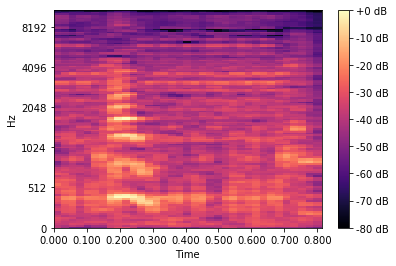

In [237]:
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_db = librosa.power_to_db(S, ref=np.max)
print(S.shape)
print(S_db.shape)

librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

#### Melspectrogram Recap
- Separate to windows: Sample the input with windows of size n_fft=2048, making hops of size hop_length=512 each time to sample the next window.
- Compute FFT (Fast Fourier Transform) for each window to transform from time domain to frequency domain.
- Generate a Mel scale: Take the entire frequency spectrum, and separate it into n_mels=128 evenly spaced frequencies.
- And what do we mean by evenly spaced? not by distance on the frequency dimension, but distance as it is heard by the human ear.
- Generate Spectrogram: For each window, decompose the magnitude of the signal into its components, corresponding to the frequencies in the mel scale.

Sources: 
- https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
- https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

### Mel-frequency cepstral coefficients (MFCCs)

- representation of the short-term power spectrum of a sound based on a linear cosine transform of a log power spectrum on a mel scale of frequency
- Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.[1] They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression
(https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

- small set of features (usually 10-20) which concisely describe the overall shape of a spectral envelope

In [238]:
mfccs = librosa.feature.mfcc(y, sr=sr)
print('{} MFCCs over {} frames'.format(*mfccs.shape))

20 MFCCs over 35 frames


The very first MFCC, the 0th coefficient, does not convey information relevant to the overall shape of the spectrum. It only conveys a constant offset, i.e. adding a constant value to the entire spectrum. Therefore, many practitioners will discard the first MFCC when performing classification. For now, we will use the MFCCs as is.
(source: https://musicinformationretrieval.com/mfcc.html)

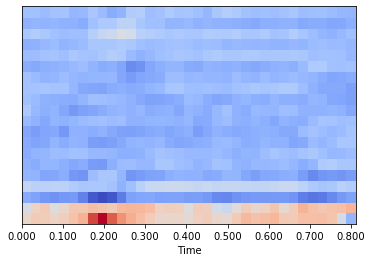

In [239]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

Apply feature scaling to mean 0 and variance 1

In [240]:
import sklearn
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))  # close to 0
print(mfccs.var(axis=1))  # close to 1

[ 6.8119594e-09  3.4059797e-09 -5.1089697e-09  5.1089697e-09
 -3.4059797e-09 -1.3623919e-08 -1.3623919e-08  6.8119594e-09
  0.0000000e+00  3.4059797e-09 -6.8119594e-09 -1.0217939e-08
  6.8119594e-09  1.5326910e-08 -1.7029899e-08  6.8119594e-09
 -1.3623919e-08 -8.5149496e-09  1.8732889e-08  1.3623919e-08]
[1.0000004  0.99999976 1.0000001  0.99999976 1.         0.99999976
 1.         1.         1.         0.9999999  1.0000001  1.0000001
 1.         1.         0.9999999  1.0000001  1.         1.
 1.0000001  0.99999976]


/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


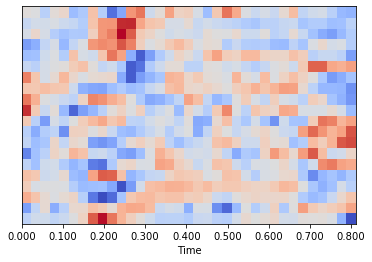

In [241]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### Chroma

A chroma vector (Wikipedia) (FMP, p. 123) is a typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, ..., B}, is present in the signal.

Code snippets:
- http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.feature.chroma_stft.html
- https://musicinformationretrieval.com/chroma.html

In [242]:
import matplotlib.pyplot as plt

def plot_chroma(chroma, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()

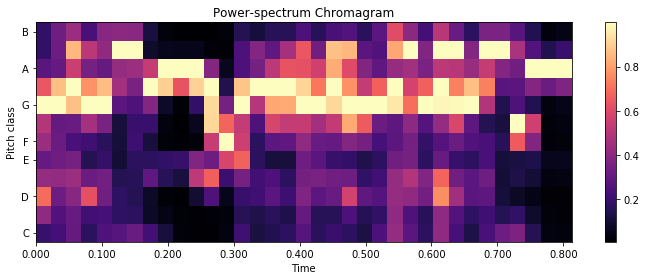

In [243]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

plot_chroma(chroma, 'Power-spectrum Chromagram')

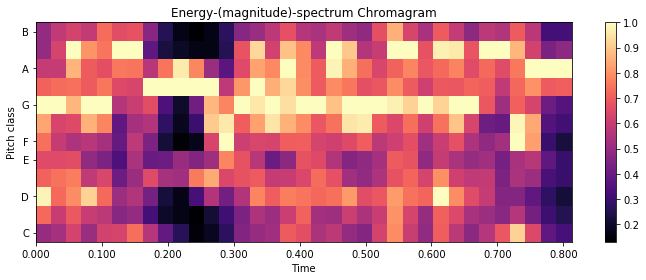

In [244]:
S = np.abs(librosa.stft(y))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
title = 'Energy-(magnitude)-spectrum Chromagram'

plot_chroma(chroma, title)

Helper functions to extract discussed features.

In [245]:
def extract_melspectrogram(result, y, sr):
    X = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
    return np.hstack((result, X))


def extract_mfcc(result, y, sr, n_mfcc=20):
    X = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)
    return np.hstack((result, X))


def extract_chroma(result, y, sr):
    stft = np.abs(librosa.stft(y))
    X = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    return np.hstack((result, X))
    

def extract_features(y, sr):
    result = np.array([])
    result = extract_melspectrogram(result, y, sr)
    result = extract_mfcc(result, y, sr)  
    result = extract_chroma(result, y, sr)
    return result


In [246]:
feats = extract_melspectrogram(np.array([]), y, sr)
len(feats)

128

In [247]:
feats = extract_mfcc(feats, y, sr)
len(feats)

148

In [248]:
feats = extract_chroma(feats, y, sr)
len(feats)

160

In [330]:
train_audio_df.head()

dia_utt                                              audio     sr   Emotion  \
0   248_1  [0.08180217, 0.32793164, 0.35280356, 0.3622203...  22050     anger   
1  499_21  [-1.919113, -3.1797762, -2.516322, -2.203696, ...  22050   neutral   
2   278_1  [0.2054725, 0.33292353, -0.033792537, -0.46749...  22050       joy   
3    38_8  [0.21824765, 0.2840394, 0.20444712, 0.20049241...  22050  surprise   
4    20_2  [-1.5331439, -2.8807135, -3.210152, -3.4175975...  22050       joy   

   emotion_class  audio_len  
0              0      17861  
1              4     159642  
2              3      46526  
3              6      35501  
4              3     102533

Extract features to X_train df

In [475]:
def run_extract(df, audio_limit=None):
    X_train = []
    for i, r in df.iterrows():
        audio = r.audio if audio_limit is None else r.audio[:audio_limit]
        X_train.append(extract_features(audio, r.sr))
    
    return np.array(X_train)

In [346]:
run_extract(train_audio_df.head(10), 3000)

0%


array([[  1.55244577,   4.39930868,  16.1377182 , ...,   0.72959059,
          0.77112681,   0.6236884 ],
       [  6.03789139,  97.40251923, 202.64164734, ...,   0.43998289,
          0.25877535,   0.36183795],
       [  4.54544783,  35.64383316,  46.27565002, ...,   0.71762508,
          0.61937195,   0.67814749],
       ...,
       [ 15.34487915, 181.20483398, 126.01973724, ...,   0.701217  ,
          0.81901836,   0.66389441],
       [  1.63524055,  24.10819435,  42.6927948 , ...,   0.52219516,
          0.65390927,   0.89789391],
       [  3.66859889,   7.94770813,  12.66978455, ...,   0.80773944,
          0.87248129,   0.84265947]])

In [250]:
X_train = run_extract(train_audio_df)
print(X_train.shape)

0%


/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1764
  warnings.warn(


(9986, 160)


In [478]:
y_train = train_audio_df['emotion_class']
print(y_train.shape)

(9986,)


In [252]:
# check for nan
assert not np.isnan(sum(X_train.ravel()))

Separate features for separate analysis

In [253]:
melspectrogram = X_train[:, :128]
mfcc = X_train[:, 128: 148]
chroma = X_train[:, 148:]

#### Checkpoint features to disk 

In [261]:
import pickle

outpath = 'data/features/{}.pkl'
names = ('mel', 'mfcc', 'chroma')
features = (melspectrogram, mfcc, chroma)
for name, feats in zip(names, features):
    path = outpath.format(name)
    with open(path, 'wb') as f:
        pickle.dump(feats, f, pickle.HIGHEST_PROTOCOL)
        print('saved ', name, ' with shape ', feats.shape, ' to ', path)


saved  mel  with shape  (9986, 128)  to  data/features/mel.pkl
saved  mfcc  with shape  (9986, 20)  to  data/features/mfcc.pkl
saved  chroma  with shape  (9986, 12)  to  data/features/chroma.pkl


In [265]:
import pickle


with open(outpath.format('mel'), 'rb') as f:
    melspectrogram = pickle.load(f)
    print(melspectrogram.shape)
    
with open(outpath.format('mfcc'), 'rb') as f:
    mfcc = pickle.load(f)
    print(mfcc.shape)
    
with open(outpath.format('chroma'), 'rb') as f:
    chroma = pickle.load(f)
    print(chroma.shape)
        

(9986, 128)
(9986, 20)
(9986, 12)


### Explore Melspectrogram

In [266]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sc_mel = scaler.fit_transform(melspectrogram)
mel_df = pd.DataFrame(sc_mel)
mel_df['emotion_class'] = y_train
mel_df.describe()

0             1             2             3             4  \
count  9.986000e+03  9.986000e+03  9.986000e+03  9.986000e+03  9.986000e+03   
mean  -2.846156e-18 -7.115389e-18 -2.205771e-17  9.250006e-18  3.557694e-19   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -2.117767e-01 -2.578658e-01 -3.224610e-01 -4.402139e-01 -5.045464e-01   
25%   -1.955469e-01 -2.449262e-01 -3.023052e-01 -4.101596e-01 -4.646640e-01   
50%   -1.733014e-01 -2.208115e-01 -2.662506e-01 -3.484412e-01 -3.660040e-01   
75%   -1.141091e-01 -1.339371e-01 -1.214860e-01 -7.840194e-02  1.518566e-02   
max    3.020771e+01  2.445457e+01  1.875748e+01  1.513819e+01  1.399854e+01   

                  5             6             7             8             9  \
count  9.986000e+03  9.986000e+03  9.986000e+03  9.986000e+03  9.986000e+03   
mean   2.846156e-17  9.961544e-18 -3.913464e-17 -2.490386e-18 -3.913464e-17   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -5.699619e-01 -6.202609e-01 -7.217607e-01 -7.008399e-01 -6.607443e-01   
25%   -5.070080e-01 -5.147957e-01 -5.740641e-01 -5.569452e-01 -5.255461e-01   
50%   -3.534559e-01 -3.236451e-01 -3.354602e-01 -3.332690e-01 -3.208991e-01   
75%    7.905183e-02  1.141105e-01  1.629017e-01  1.483956e-01  1.161839e-01   
max    1.626735e+01  1.909650e+01  1.367080e+01  1.369231e+01  1.703945e+01   

       ...           119           120           121           122  \
count  ...  9.986000e+03  9.986000e+03  9.986000e+03  9.986000e+03   
mean   ...  1.102885e-17  1.565386e-17  3.557694e-18 -1.423078e-17   
std    ...  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min    ... -3.312066e-01 -2.999347e-01 -2.841308e-01 -2.708953e-01   
25%    ... -2.990483e-01 -2.709374e-01 -2.571859e-01 -2.442273e-01   
50%    ... -2.396427e-01 -2.206323e-01 -2.100271e-01 -1.995215e-01   
75%    ... -5.617879e-02 -5.915263e-02 -6.192873e-02 -5.591815e-02   
max    ...  4.069931e+01  3.740228e+01  3.716416e+01  4.380240e+01   

                123           124           125           126           127  \
count  9.986000e+03  9.986000e+03  9.986000e+03  9.986000e+03  9.986000e+03   
mean   3.557694e-19  4.269233e-18 -1.814424e-17  4.447118e-18  1.423078e-17   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -2.494168e-01 -2.221660e-01 -2.163666e-01 -1.921317e-01 -1.363121e-01   
25%   -2.245586e-01 -2.020397e-01 -1.976702e-01 -1.762340e-01 -1.252877e-01   
50%   -1.835393e-01 -1.700977e-01 -1.676096e-01 -1.513759e-01 -1.072400e-01   
75%   -5.463663e-02 -6.584973e-02 -7.221401e-02 -7.076927e-02 -5.443408e-02   
max    5.064463e+01  5.700973e+01  3.652525e+01  4.284044e+01  6.165616e+01   

       emotion_class  
count    9986.000000  
mean        3.556379  
std         1.629681  
min         0.000000  
25%         3.000000  
50%         4.000000  
75%         4.000000  
max         6.000000  

[8 rows x 129 columns]

In [267]:
def sea_corr_plot(corr):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


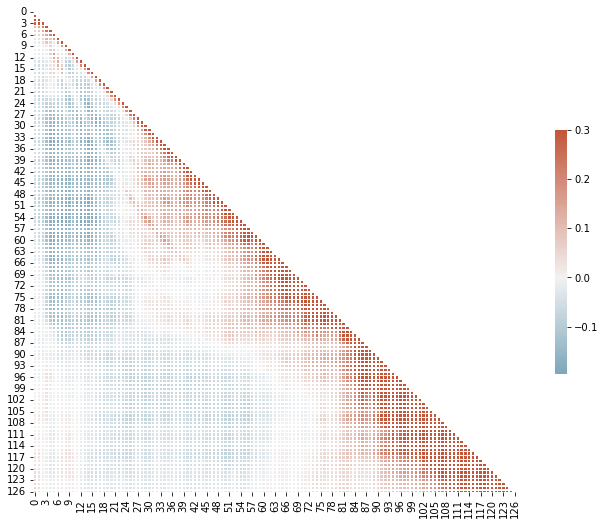

In [268]:
mel_corr = mel_df.corr()
sea_corr_plot(mel_corr)

Looks like there is some feature redundancy here.

The melspectrogram PCA plots suggest, generally speaking, that features are most highly correlated with their neighbor frequencies. Some of the features on the lower end of the spectrum are correlated with a larger neighborhood of features.

In [270]:
def print_high_dv_corr(corr, thresh=0.05):
    # Correlation with output variable
    # features with high correlation to output variable 
    cor_target = abs(corr["emotion_class"]) 
    cor_target.drop('emotion_class', inplace=True)
    print(cor_target[cor_target > thresh])
    
    
print_high_dv_corr(mel_corr)

3     0.056539
4     0.057965
5     0.054202
6     0.053937
7     0.050692
45    0.061780
47    0.052008
50    0.050809
51    0.052726
57    0.056395
62    0.057057
63    0.057573
64    0.055945
65    0.059982
66    0.054631
67    0.057581
68    0.058714
69    0.062472
70    0.063484
71    0.056730
72    0.060313
73    0.065862
74    0.060461
80    0.054128
81    0.060725
82    0.058935
83    0.066283
84    0.055717
Name: emotion_class, dtype: float64


Unsurprising no single feature correlates strongly to the DV emotion, rather a range of frequencies have weak correlations.

In [278]:
from sklearn.decomposition import PCA

def try_pca(df, scale=False, sig=4, stop_thresh=0.001):
    results = []
    for c in range(1, len(df.columns), 1):
        pca = PCA(n_components=c)
        pca.fit(df)
        evr = pca.explained_variance_ratio_
        min_evr = min(evr)
        results.append([c, round(sum(evr), sig), round(min_evr, sig)])
        if min_evr < stop_thresh: 
            break  
        
    tmp = pd.DataFrame(np.array(results))
    tmp.columns = ['c', 'explain', 'min ft']
    return tmp
        
mel_pca = try_pca(mel_df)

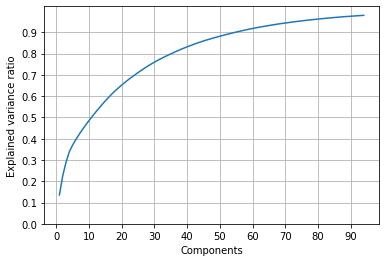

In [298]:
def plot_pca(df, x_step=10):
    plt.plot(df.c.to_numpy(), df.explain.to_numpy())
    plt.grid()
    plt.xlabel("Components")
    plt.ylabel("Explained variance ratio")
    plt.yticks(np.arange(0, 1.0, 0.1))
    plt.xticks(np.arange(0, max(df.c) + 1, x_step))
    
plot_pca(mel_pca)

35 components explain 80% of the variance, 54 explain 90% and additional features give little from there.

### Explore MFCC

In [84]:
sc_mfcc = scaler.fit_transform(mfcc)
mfcc_df = pd.DataFrame(sc_mfcc)
mfcc_df['emotion_class'] = y_train
mfcc_df.describe()

0             1             2             3             4  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean  -5.861978e-17 -1.696421e-16  8.526513e-17  1.492140e-16  1.021405e-16   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -3.971131e+00 -4.026681e+00 -3.314304e+00 -3.185887e+00 -4.299234e+00   
25%   -5.710220e-01 -6.270841e-01 -6.519996e-01 -6.712812e-01 -6.518933e-01   
50%    1.443419e-02  2.451026e-02  3.979466e-03  1.582908e-02 -6.457300e-03   
75%    6.752030e-01  6.497192e-01  6.618312e-01  6.746847e-01  6.585118e-01   
max    3.510918e+00  3.144254e+00  2.864100e+00  3.744788e+00  4.409858e+00   

                  5             6             7             8             9  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean   4.440892e-18 -8.881784e-18  5.728751e-17 -1.243450e-16 -4.263256e-17   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -4.208297e+00 -3.084919e+00 -3.798527e+00 -3.721317e+00 -4.206643e+00   
25%   -6.631410e-01 -6.261286e-01 -6.547901e-01 -6.718280e-01 -6.299978e-01   
50%   -2.630926e-02 -1.351311e-02 -2.176111e-02 -3.702618e-02  6.022083e-02   
75%    6.710022e-01  6.305166e-01  6.077936e-01  6.770131e-01  6.955483e-01   
max    3.001711e+00  4.079915e+00  3.329458e+00  3.089302e+00  4.351775e+00   

       ...            11            12            13            14  \
count  ...  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean   ... -3.552714e-17 -7.105427e-18  3.552714e-17 -8.881784e-18   
std    ...  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min    ... -4.588781e+00 -4.137116e+00 -5.323559e+00 -7.459766e+00   
25%    ... -6.347620e-01 -6.476393e-01 -6.482149e-01 -5.635857e-01   
50%    ... -4.195743e-03  7.265580e-03 -1.735095e-02 -6.529473e-03   
75%    ...  6.234874e-01  6.478555e-01  6.313089e-01  5.631291e-01   
max    ...  3.489936e+00  3.956982e+00  3.944374e+00  4.624009e+00   

                 15            16            17            18            19  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean   3.552714e-18  1.598721e-17  2.131628e-17  7.105427e-18  3.552714e-18   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -3.363886e+00 -2.972750e+00 -2.656131e+00 -3.087727e+00 -3.835286e+00   
25%   -6.901136e-01 -6.419681e-01 -5.929994e-01 -6.397275e-01 -5.838385e-01   
50%   -1.245017e-02 -9.276331e-02 -5.675571e-02 -1.117058e-01 -4.650712e-02   
75%    6.417717e-01  5.382829e-01  4.899077e-01  5.524088e-01  5.617980e-01   
max    5.065849e+00  4.522690e+00  7.137419e+00  5.955714e+00  4.843875e+00   

       emotion_class  
count    1000.000000  
mean        3.589000  
std         1.623797  
min         0.000000  
25%         3.000000  
50%         4.000000  
75%         4.000000  
max         6.000000  

[8 rows x 21 columns]

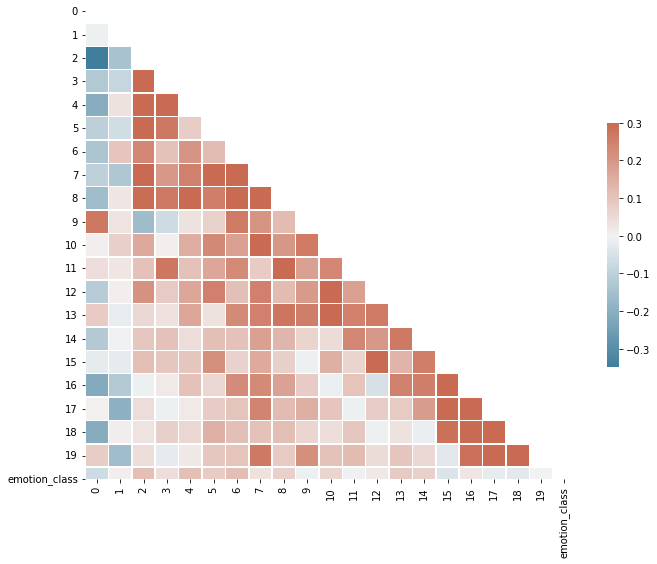

In [85]:
mfcc_corr = mfcc_df.corr()
sea_corr_plot(mfcc_corr)

Some coefficients are correlated, some are not, doesn't seem worth doing a reduction on 20 features.

In [87]:
print_high_dv_corr(mfcc_corr)

0     0.069931
2     0.112732
4     0.114207
5     0.086862
6     0.115562
8     0.072794
10    0.063395
13    0.087286
14    0.074092
Name: emotion_class, dtype: float64


Some promise here but generally still weak correlations with DV

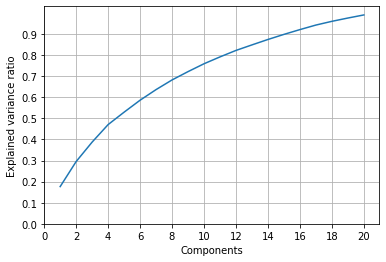

In [299]:
plot_pca(try_pca(mfcc_df), x_step=2)

Using PCA we can reduce to 11 features and explain 80% or to 15 and get 90%

### Explore Chroma

In [89]:
sc_chroma = scaler.fit_transform(chroma)
chroma_df = pd.DataFrame(sc_chroma)
chroma_df['emotion_class'] = y_train
chroma_df.describe()

0             1             2             3             4  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean   6.075140e-16 -1.421085e-16  2.984279e-16  1.088019e-16 -4.529710e-16   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -5.327714e+00 -5.036691e+00 -4.791400e+00 -4.006364e+00 -3.750381e+00   
25%   -5.659657e-01 -6.107421e-01 -5.897820e-01 -5.626357e-01 -6.447222e-01   
50%    3.277763e-02  2.324217e-02  3.485546e-02  3.899722e-02  4.735455e-02   
75%    6.601762e-01  6.450375e-01  6.586077e-01  6.369750e-01  6.619567e-01   
max    3.118678e+00  3.361698e+00  3.511951e+00  3.247046e+00  4.140744e+00   

                  5             6             7             8             9  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean  -4.281020e-16  3.099743e-16  1.456613e-16  5.577760e-16  2.380318e-16   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -3.785401e+00 -3.470187e+00 -4.700035e+00 -4.498727e+00 -3.302649e+00   
25%   -6.599597e-01 -6.595260e-01 -6.582602e-01 -6.397055e-01 -6.306528e-01   
50%    4.086913e-02  8.574516e-02  8.942658e-03  4.910478e-03  7.039600e-02   
75%    6.857714e-01  7.037904e-01  7.282457e-01  7.046362e-01  6.890708e-01   
max    2.633829e+00  3.768669e+00  2.540812e+00  3.574076e+00  3.339565e+00   

                 10            11  emotion_class  
count  1.000000e+03  1.000000e+03    1000.000000  
mean  -5.151435e-17 -2.913225e-16       3.589000  
std    1.000500e+00  1.000500e+00       1.623797  
min   -3.171630e+00 -4.597521e+00       0.000000  
25%   -6.365968e-01 -5.760985e-01       3.000000  
50%    9.151919e-02  4.419731e-02       4.000000  
75%    6.704491e-01  6.602706e-01       4.000000  
max    3.569325e+00  4.039834e+00       6.000000

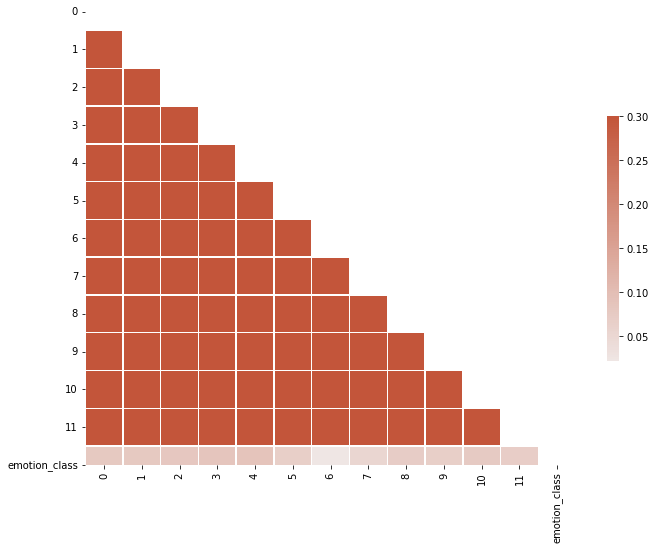

In [90]:
chroma_corr = chroma_df.corr()
sea_corr_plot(chroma_corr)

Looks like the Chroma are highly correlated with each other around 0.3

In [91]:
print_high_dv_corr(chroma_corr)

0     0.079151
1     0.078484
2     0.080581
3     0.086341
4     0.088588
5     0.068607
7     0.054170
8     0.072888
9     0.066279
10    0.076324
11    0.069776
Name: emotion_class, dtype: float64


Each are weakly correlated with the DV

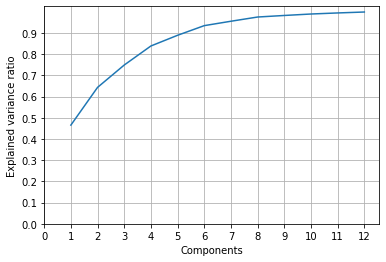

In [301]:
plot_pca(try_pca(chroma_df), x_step=1)

Five features can explain almost 90% of the data

## EDA Questions

- How many PCA components to use?

- What audio length to use? (fixing starting point at 0 and varying length)

- Metric can be Silhouette Score to measure cluster/category effectiveness. 


In [302]:
def top_2_pca(df):
    pca = PCA(2)
    reduced = pca.fit_transform(df)
    df = pd.DataFrame(reduced)
    df.columns = ['x', 'y']
    df['label'] = np.array(label_encoder.inverse_transform(y_train))
    return df

In [307]:
from matplotlib.pyplot import figure

def pca_scatter(df, label_col='label'):
    figure(figsize=(18, 12), dpi=80)
    groups = df.groupby(label_col)
    for name, group in groups:
        plt.plot(np.array(group.x), np.array(group.y), marker='o', linestyle='', 
                 markersize=4, label=name)

    plt.legend()

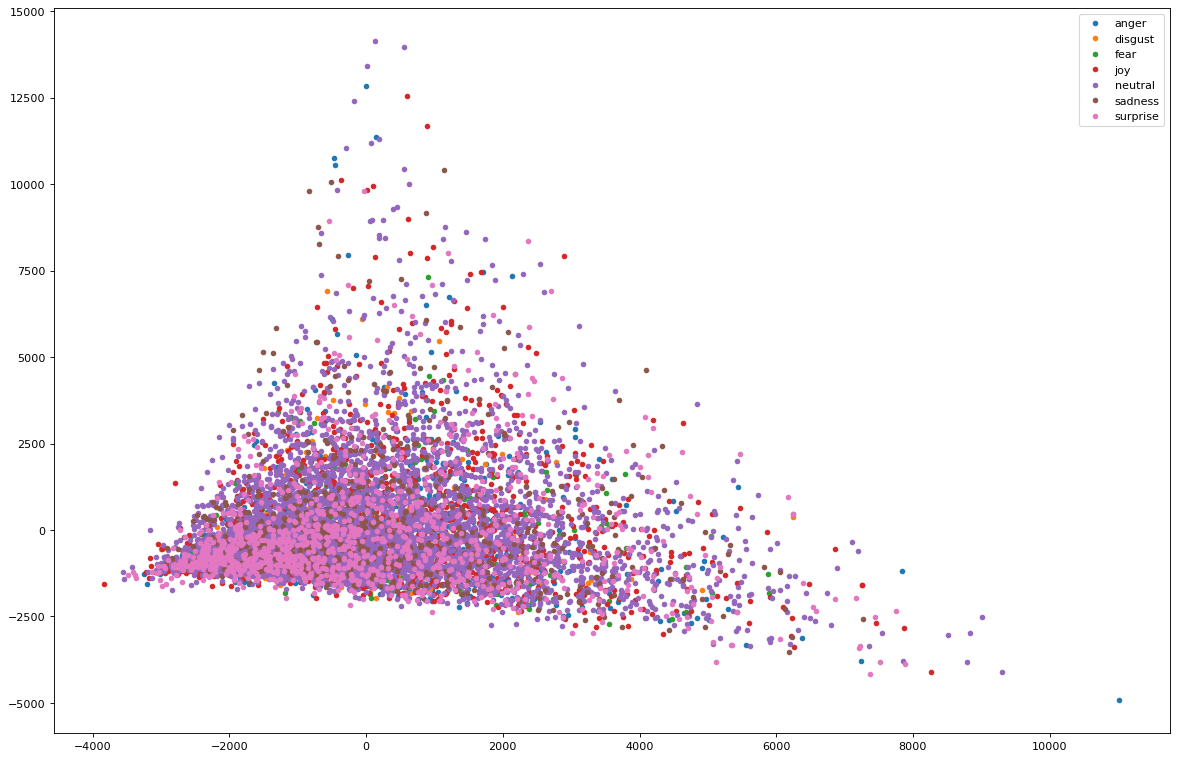

In [308]:
pca_scatter(top_2_pca(melspectrogram))

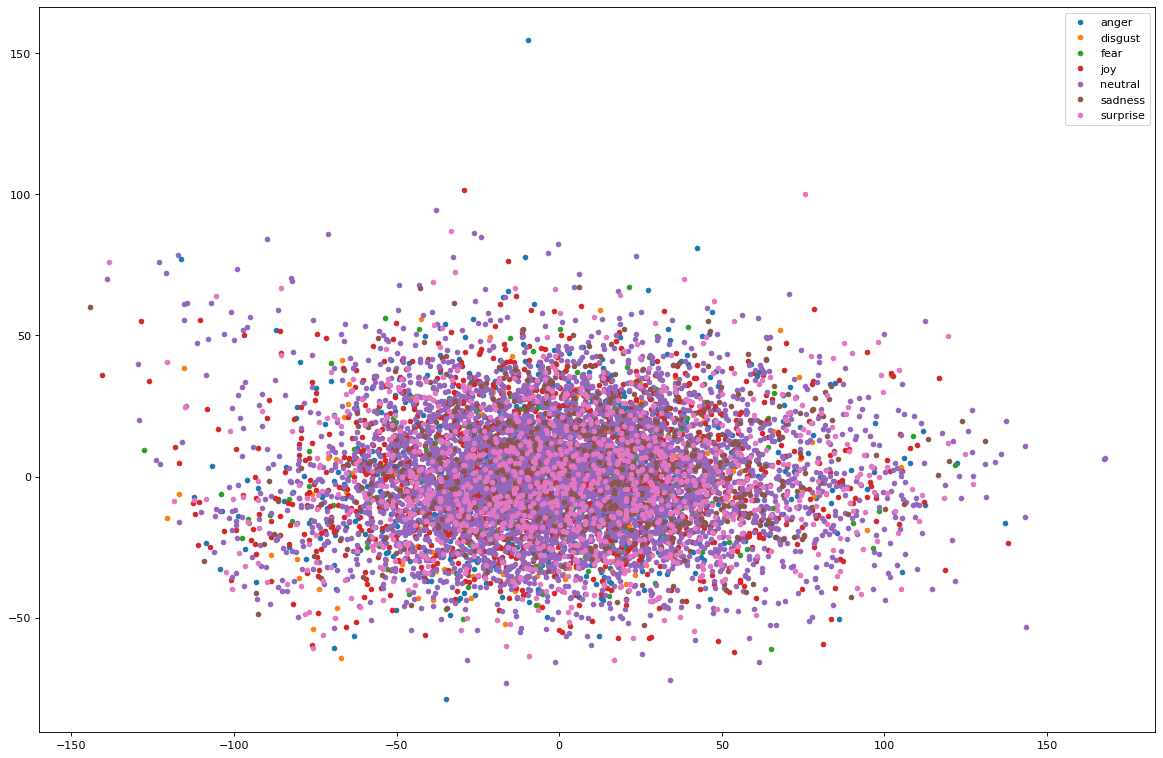

In [309]:
pca_scatter(top_2_pca(mfcc))

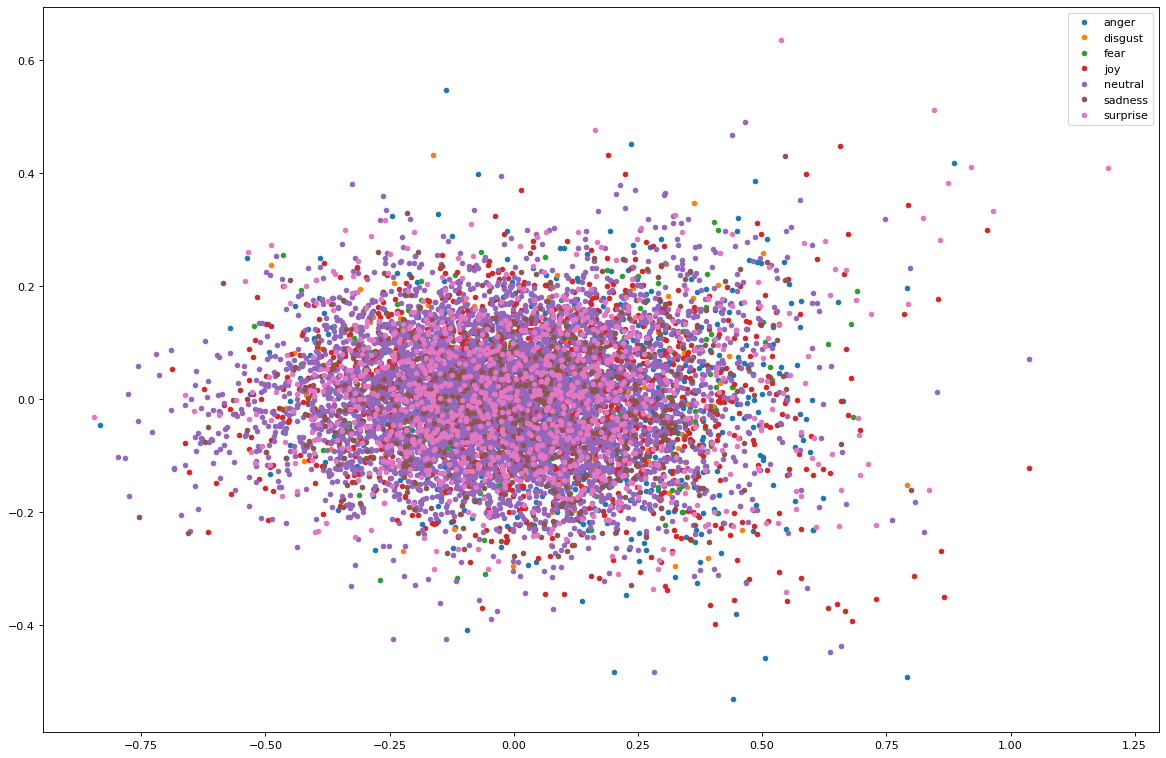

In [310]:
pca_scatter(top_2_pca(chroma))

### Quantifying PCA in terms of Silhouette Score

#### Baseline

In [328]:
feature_sets = dict(
    mel=melspectrogram,
    mfcc=mfcc,
    chroma=chroma
)
for name, fs in feature_sets.items():
    print(name, silhouette_score(fs, y_train))

mel -0.08516744160835431
mfcc -0.04590746144493875
chroma -0.05952048726285968


The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [323]:
# Compute Silhouette score for various PCA thresholds 

def run_pca(df, c_s):
    scores = []
    for c in c_s:
        pca = PCA(n_components=c)
        reduced = pca.fit_transform(df)
        scores.append(silhouette_score(reduced, y_train))   
    return scores
        
c_s = list(range(1, min(melspectrogram.shape), 10))
scores = run_pca(melspectrogram, c_s)

Text(0, 0.5, 'Silhouette Score')

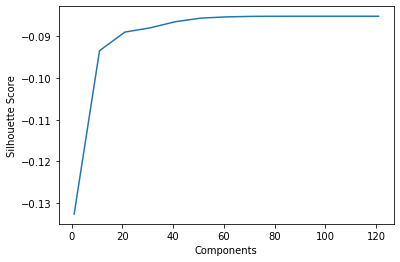

In [324]:
plt.plot(c_s, scores)
plt.xlabel("Components")
plt.ylabel("Silhouette Score")

Score doesn't really improve after 40~ components

Text(0, 0.5, 'Silhouette Score')

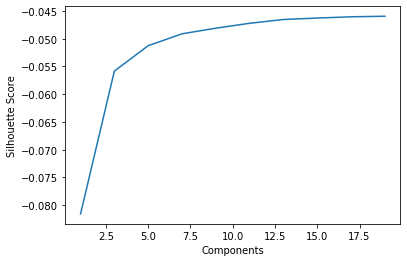

In [325]:
c_s = list(range(1, min(mfcc.shape), 2))
scores = run_pca(mfcc, c_s)
plt.plot(c_s, scores)
plt.xlabel("Components")
plt.ylabel("Silhouette Score")

Text(0, 0.5, 'Silhouette Score')

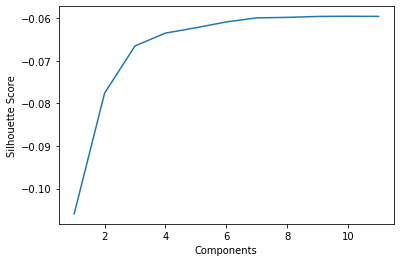

In [326]:
c_s = list(range(1, min(chroma.shape)))
scores = run_pca(chroma, c_s)
plt.plot(c_s, scores)
plt.xlabel("Components")
plt.ylabel("Silhouette Score")

### Effects of truncating audio 



I know the 25% quantile of the audio length is around 35,000, 
 so 75% of the data is longer than this. I can try truncating to 10K, 20K, 30K 
 and assessing performance.

In [500]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


def eval_with_limit(limit: int):
    X_train_trunc = run_extract(train_audio_df, audio_limit=limit)
    X_test = run_extract(test_audio_df, audio_limit=limit)
    
    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    model.fit(X_train_trunc, y_train_trunc)
    return model.predict(X_test)


In [ ]:
limit_results = []
for limit in (3000, 6000, 9000):
    prediction = eval_with_limit(limit)
    limit_results.append((limit, prediction))


In [ ]:
for limit in range(10 * 1000, 200 * 1000, 10 * 1000):
    prediction = eval_with_limit(limit)
    limit_results.append((limit, prediction))


In [501]:
from sklearn.metrics import f1_score, accuracy_score

y_test = test_df['emotion_class']

def plot_limit_results(limit_results):
    limits = [x[0] for x in limit_results]
    fscores = []
    accuracies = []
    for limit, y_pred in limit_results:
        fscores.append(f1_score(y_test, y_pred, average='weighted'))
        accuracies.append(accuracy_score(y_test, y_pred))

    fig, axs = plt.subplots(2)
    axs[0].plot(limits, fscores)
    axs[1].plot(limits, accuracies)
    plt.setp(axs[0], ylabel='f1', xlabel='limit')
    plt.setp(axs[1], ylabel='accuracy', xlabel='limit')

In [503]:
for limit in list(range(47000, 53001, 1000)) + [906 * 1000]:
    prediction = eval_with_limit(limit)
    limit_results.append((limit, prediction))

In [506]:
limit_results.sort(keylambda x: x[0])

TypeError: sort() takes no positional arguments

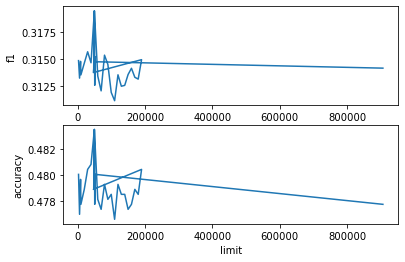

In [504]:
plot_limit_results(limit_results)

Performance appears to be best at 50,000 length

## Zero rule baseline


In [477]:
label_counts = train_df['Emotion'].value_counts()
total_labels = label_counts.sum()
correct = max(label_counts)
max_label = label_counts[label_counts == correct].index[0]
accuracy = correct / total_labels * 100
print(f'Always predict "{max_label}" for {accuracy:.2f}% accuracy')

Always predict "neutral" for 47.15% accuracy


# Summary

In this notebook I first got a sense of the tabular labeled CSV data. I listened to the outlier short and long utterances which lead me to remove to unintelligle short utterances. I noted that 6 speakers comprise 83% of the data and the presence of a 17x class imbalance b/w fear and neutral and b/w digust and neutral.

I then investigated the following feature extraction methods: Mel-scaled spectrogram,
Mel-frequency cepstral coefficients, Chroma. 
The features produced by these methods are individually weakly correlated with the DV, emotion. Each of the three sets of features can be reduced using PCA and still capture a significant portion of the data's characteristics. This would be especially useful for reducing the 128 melspectrogram features down to ~50 to reduce model complexity.

In [62]:
# which classifiers? LogisticRegression, RandomForest, MLPClassifier, SVM, XGBoost